In [137]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

In [138]:
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.linewidth'] = 1.5

def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

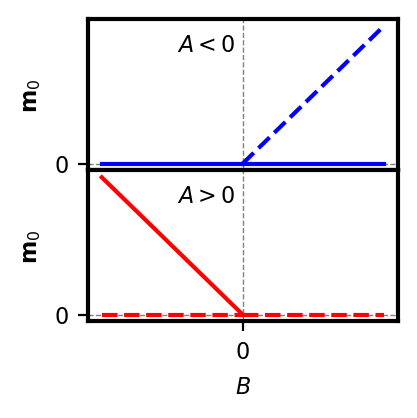

In [99]:
fig, ax = plt.subplots(2, 1, dpi=200, figsize=(2, 2), sharex=True, sharey=True)

pos = np.linspace(0, 1, 10)
neg = np.linspace(-1, 0, 10)

ax[0].plot(pos, pos*0, linestyle='-', color='blue')
ax[0].plot(neg, neg*0, linestyle='-', color='blue')
#ax[0].plot(neg, neg, linestyle='-', color='blue')
ax[0].plot(pos, pos, linestyle='--', color='blue')

ax[1].plot(neg, neg*0, linestyle='--', color='red')
ax[1].plot(pos, pos*0, linestyle='--', color='red')
ax[1].plot(neg, -neg, linestyle='-', color='red')
        
ax[0].text(-0.05, 0.95, '$A < 0$', va='top', ha='right')
ax[1].text(-0.05, 0.95, '$A > 0$', va='top', ha='right')

fig.subplots_adjust(hspace=0)
ax[1].set_xlabel('$B$')
for a in ax:
    a.set_ylabel('$\\mathbf{m}_0$')
    a.set_xticks([0])
    a.set_yticks([0])
    a.axvline(0, linestyle='--', linewidth=0.5, color='grey', zorder=-1)
    a.axhline(0, linestyle='--', linewidth=0.5, color='grey', zorder=-1)

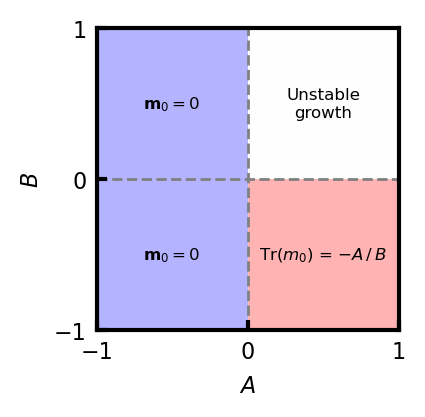

In [141]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2, 2))
R = np.linspace(-1, 1, 10)
A, B = np.meshgrid(R, R)
C = np.zeros(A.shape)

C[A <= 0] = -1
C[np.logical_and(A >= 0, B <= 0)] = 1
ax.imshow(C, cmap='bwr', alpha=0.3, origin='lower', extent=[-1, 1, -1, 1])
ax.axvline(0, linestyle='--', linewidth=1, color='grey', zorder=1)
ax.axhline(0, linestyle='--', linewidth=1, color='grey', zorder=1)
ax.set(xticks=[-1, 0, 1], yticks=[-1, 0, 1])
ax.tick_params(which='both', direction='in', width=1.5)
twargs = dict(va='center', ha='center', fontsize=6)
ax.text(0.5, 0.5, 'Unstable\ngrowth', **twargs)
ax.text(0.5, -0.5, r'Tr($m_0$) = $- A \,/\, B$', **twargs)
ax.text(-0.5, 0.5, r'$\mathbf{m}_0 = 0$', **twargs)
ax.text(-0.5, -0.5, r'$\mathbf{m}_0 = 0$', **twargs)

ax.set(xlabel='$A$', ylabel='$B$')
plt.savefig('Myosin_Only_phasediagram.svg', bbox_inches='tight', dpi=300)

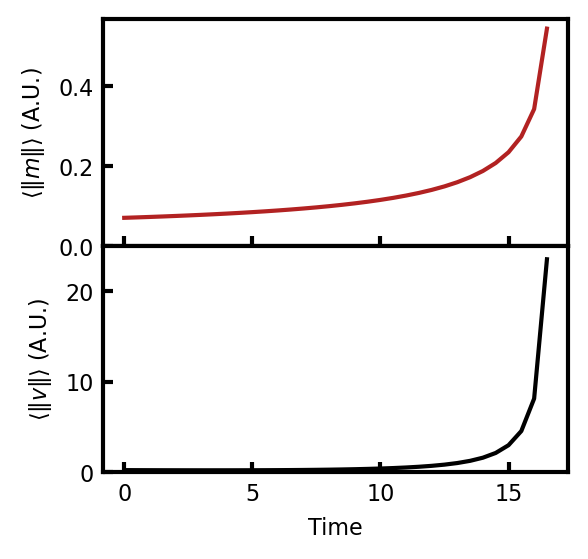

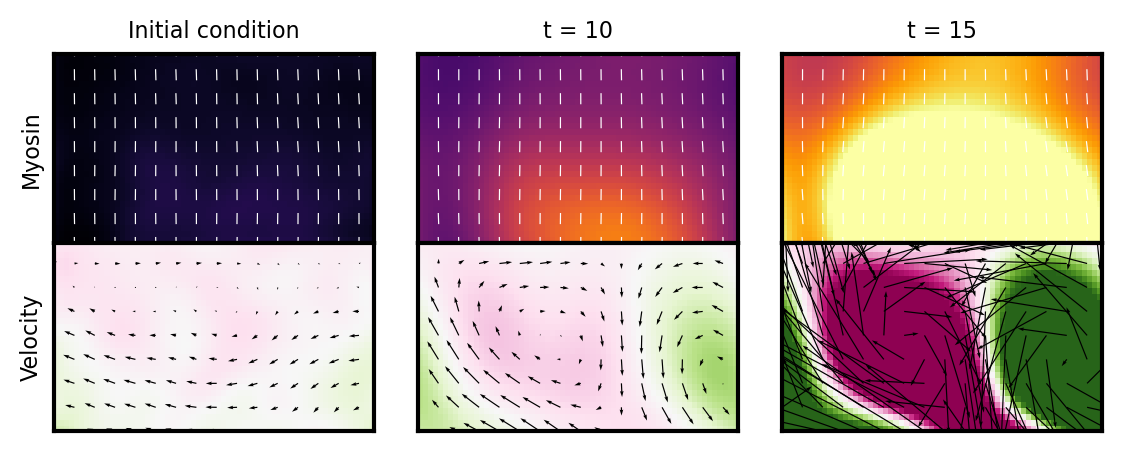

In [140]:
name = 'Quadratic Diffusion_s2'
folder = name.split('_')[0]

slc = slice(1, -2)
skip = 4
tt = [0, 10, 15]


with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    #Collect data
    mij = h5f['tasks/m'][slc]
    vi  = h5f['tasks/v'][slc]
    c   = h5f['tasks/c'][slc]
    t0  = h5f['scales/sim_time'][slc]
    t0 = t0 - t0.min()
  
    fig1, ax = plt.subplots(2, 1, dpi=200, figsize=(3, 3), sharex=True)
    ax[0].plot(t0, np.mean(np.linalg.norm(mij, axis=(1, 2)), axis=(1, 2)), color='firebrick')    
    ax[1].plot(t0, np.mean(np.linalg.norm(vi, axis=(1)), axis=(1, 2)), color='black')
    
    ax[0].set_ylabel(r"$\langle|\!|m|\!|\rangle$ (A.U.)")
    ax[1].set_ylabel(r"$\langle|\!|v|\!|\rangle$ (A.U.)")
    for a in ax: a.tick_params(which='both', direction='in', width=1.5)
    
    ax[1].set_xlabel('Time')
    ax[0].set(ylim=[0, ax[0].get_ylim()[1]], yticks=[0, 0.2, 0.4])
    ax[1].set(ylim=[0, 25], yticks=[0, 10, 20], xticks=[0, 5, 10, 15])
    fig1.subplots_adjust(hspace=0)
    
    x = np.linspace(0, h5f['params/Lx'], mij.shape[-2])
    y = np.linspace(0, h5f['params/Ly'], mij.shape[-1])  
    
    wi = np.gradient(vi[:, 1], x, axis=-2) - np.gradient(vi[:, 0], y, axis=-1)
    wmax = np.std(wi[:-1])
        
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    
    w = len(tt) * 2 + 1
    fig2, ax = plt.subplots(2, len(tt), dpi=200, figsize=(w, 2.5))
    for i, ti in enumerate(tt):
        idx = np.argmin(np.abs(t0 - ti))
        mi = mij[idx]
        m, n = get_director_magnitude(mi)
        ax[0, i].set_title(f't = {ti:g}')
        pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=0.06, vmax=0.20)
        ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
        
        v, w = vi[idx], wi[idx]
        pcW = ax[1, i].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-wmax, vmax=wmax)
        ax[1, i].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, 
                        color="black", scale=1e1)

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')
        a.set_ylim([0, a.get_ylim()[1]/2])
    ax[0, 0].set_title('Initial condition')
    
    ax[0, 0].set_ylabel('Myosin')
    ax[1, 0].set_ylabel('Velocity')
        
    fig2.subplots_adjust(wspace=0.02, hspace=0)
    
fig1.savefig('Diffusion_trajectory.svg', bbox_inches='tight', dpi=300)
fig2.savefig('Diffusion_images.svg', bbox_inches='tight', dpi=300)

\begin{equation}
    c^{\star} = \frac{A m + B m^2 - \mathbf{v} \cdot \nabla m}{k A m}
\end{equation}

0.9804356973812215 0.7211751872059249
1.6026597836162686 1.2861837590725962


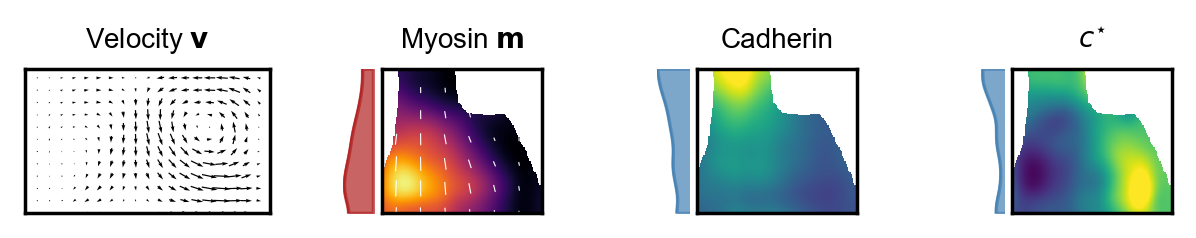

In [204]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 250
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

import os
from scipy.ndimage import gaussian_filter
from utils.plot_utils import *


def plot_cut(ax, cut, color):
    y = np.linspace(*ax.get_ylim(), cut.shape[0])
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    ax_Y.plot(cut, y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 0, cut, color=color, alpha=0.7)
    ax_Y.invert_xaxis()
    ax_Y.axis('off')
    return ax_Y

tt = 30
loaddir = '../Public/WT/ECad-GFP/ensemble/'
c0 = np.load(os.path.join(loaddir, 'raw2D.npy'), mmap_mode='r')[tt].copy()
c0 = gaussian_filter(c0, sigma=7)
loaddir = '../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
m0 = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')[tt].copy()
v0 = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')[tt].copy()
mask = np.load('../Public/Masks/Dynamic_PMG_CF_mask.npy')[tt]

AP = np.linspace(0, 452, 200)
DV = np.linspace(0, 533, 236)

A, B, k = 0.33, -.66, 0.6

gradm = np.stack([
    np.gradient(m0, DV, axis=-2),
    np.gradient(m0, AP, axis=-1)])
vgradm = np.einsum('kijyx,kyx->ijyx', gradm, v0)
vgradm = vgradm[0, 0] + vgradm[1, 1]
trm = m0[0, 0] + m0[1, 1]
c1 = (A * trm + B * trm**2 - vgradm) / (k * trm * A)


fig, ax = plt.subplots(1, 4, figsize=(6.5, .75))
ax = ax.flatten()

cut_c0 = np.mean(c0[:118, 80:120], axis=-1)
cut_c1 = np.mean(c1[:118, 80:120], axis=-1)
cut_m  = np.mean(trm[:118, 80:120], axis=-1)
m0[..., ~mask] = np.nan
c0[~mask] = np.nan
c1[~mask] = np.nan

plot_vector2D(ax[0], v0)
plot_tensor2D(ax[1], m0)
color_2D(ax[2], c0, vmin=0.6, vmax=1.6)
color_2D(ax[3], c1, vmin=0.6, vmax=1.6)

print(np.min(cut_c0), np.min(cut_c1))
print(np.max(cut_c0), np.max(cut_c1))
plot_cut(ax[1], cut_m, color='firebrick')
plot_cut(ax[2], cut_c0, color='steelblue').set(xlim=[1.6, 0.6])
plot_cut(ax[3], cut_c1, color='steelblue').set(xlim=[1.6, 0.6])

for a in ax[1:]:
    a.set_xlim([160, 455])

ax[0].set_title('Velocity $\\mathbf{v}$')
ax[1].set_title('Myosin $\\mathbf{m}$')
ax[2].set_title('Cadherin')
ax[3].set_title('$c^{\\star}$')
    
fig.subplots_adjust(wspace=0.0)

plt.savefig('ControlField.png', dpi=300, bbox_inches='tight')

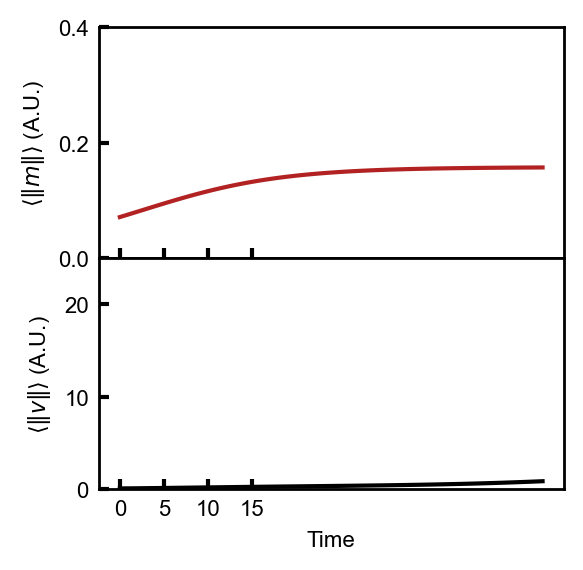

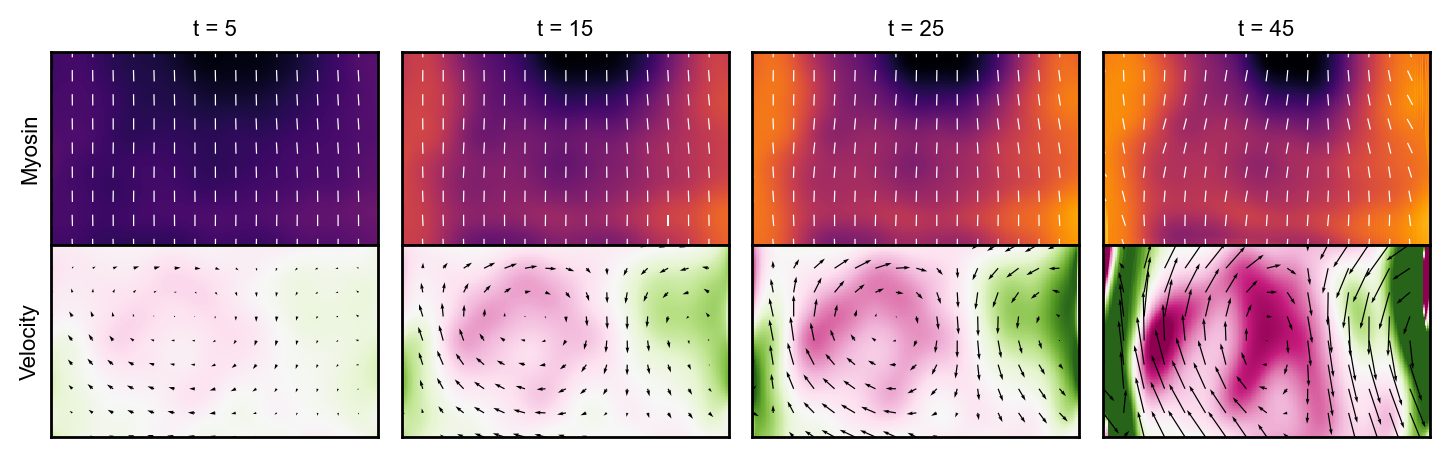

In [205]:
name = 'Cadherin_s10'
folder = name.split('_')[0]

slc = slice(1, -2)
skip = 16
tt = [5, 15, 25, 45]


with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    #Collect data
    mij = h5f['tasks/m'][slc]
    vi  = h5f['tasks/v'][slc]
    c   = h5f['tasks/c'][slc]
    t0  = h5f['scales/sim_time'][slc]
    t0 = t0 - t0.min()
  
    fig1, ax = plt.subplots(2, 1, dpi=200, figsize=(3, 3), sharex=True)
    ax[0].plot(t0, np.mean(np.linalg.norm(mij, axis=(1, 2)), axis=(1, 2)), color='firebrick')    
    ax[1].plot(t0, np.mean(np.linalg.norm(vi, axis=(1)), axis=(1, 2)), color='black')
    
    ax[0].set_ylabel(r"$\langle|\!|m|\!|\rangle$ (A.U.)")
    ax[1].set_ylabel(r"$\langle|\!|v|\!|\rangle$ (A.U.)")
    for a in ax: a.tick_params(which='both', direction='in', width=1.5)
    
    ax[1].set_xlabel('Time')
    ax[0].set(ylim=[0, ax[0].get_ylim()[1]], yticks=[0, 0.2, 0.4])
    ax[1].set(ylim=[0, 25], yticks=[0, 10, 20], xticks=[0, 5, 10, 15])
    fig1.subplots_adjust(hspace=0)
    
    x = np.linspace(0, h5f['params/Lx'], mij.shape[-2])
    y = np.linspace(0, h5f['params/Ly'], mij.shape[-1])  
    
    wi = np.gradient(vi[:, 1], x, axis=-2) - np.gradient(vi[:, 0], y, axis=-1)
    wmax = 2 * np.std(wi)
        
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    
    w = len(tt) * 2 + 1
    fig2, ax = plt.subplots(2, len(tt), dpi=200, figsize=(w, 2.5))
    for i, ti in enumerate(tt):
        idx = np.argmin(np.abs(t0 - ti))
        mi = mij[idx]
        m, n = get_director_magnitude(mi)
        ax[0, i].set_title(f't = {ti:g}')
        pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=0.06, vmax=0.25)
        ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
        
        v, w = vi[idx], wi[idx]
        pcW = ax[1, i].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-wmax, vmax=wmax)
        ax[1, i].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, 
                        color="black", scale=1e1)

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')
        a.set_ylim([0, a.get_ylim()[1]/2])
    
    ax[0, 0].set_ylabel('Myosin')
    ax[1, 0].set_ylabel('Velocity')
        
    fig2.subplots_adjust(wspace=0.02, hspace=0)
    
#fig2.savefig('Cadherin_images.png', bbox_inches='tight', dpi=300)